# 1. Import Libraries

In [1]:
#Standard libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import time 

# library for sampling
from scipy.stats import uniform

# libraries for Data Download
import datetime
from pandas_datareader import data as pdr
import fix_yahoo_finance as yf

# sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import linear_model

# Keras
import keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.regularizers import L1L2

Using TensorFlow backend.


# 2. Create Classes

In [2]:
# Define callback class
# Resets the states after each epoch (after going through a time series)
class ModelStateReset(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        self.model.reset_states()
reset = ModelStateReset()

# Different Approach
#class modLSTM(LSTM):
#    def call(self, x, mask=None):
#        if self.stateful: 
#             self.reset_states()
#        return super(modLSTM, self).call(x, mask)

# 3. Write Functions

In [3]:
# Function to create model, required for KerasClassifier
def create_shallow_LSTM(dropout_rate=None, recurrent_dropout=None, look_back=None, num_features = None, num_samples=None, LSTM_units=None, Dense_units=None, recurrent_regularizer=None, activity_regularizer=None):

    model = Sequential()

    model.add(LSTM(LSTM_units, batch_input_shape=(num_samples, look_back, num_features), stateful=True, recurrent_dropout=recurrent_dropout, recurrent_regularizer=recurrent_regularizer, activity_regularizer=activity_regularizer)) 
    
    model.add(Dropout(dropout_rate=dropout_rate))
            
    model.add(Dense(Dense_units, activation='sigmoid',  kernel_initializer='he_normal'))

    model.compile(loss='binary_crossentropy',  optimizer = "adam", metrics=['accuracy'])

    return model

# 4. Data

## 4.1 Import Raw Data

In [4]:
start_sp = datetime.datetime(1980, 1, 2) 
end_sp = datetime.datetime(2019, 2, 28)

yf.pdr_override() 
sp500 = pdr.get_data_yahoo('^GSPC', 
                           start_sp,
                             end_sp)
sp500.shape

[*********************100%***********************]  1 of 1 downloaded


(9874, 6)

## 4.2 Create Features

In [5]:
# Compute the logarithmic returns using the Closing price 
sp500['Log_Ret_1d'] = np.log(sp500['Close'] / sp500['Close'].shift(1))

# Compute logarithmic returns using the pandas rolling mean function
sp500['Log_Ret_1w'] = pd.Series(sp500['Log_Ret_1d']).rolling(window=5).sum()
sp500['Log_Ret_2w'] = pd.Series(sp500['Log_Ret_1d']).rolling(window=10).sum()
sp500['Log_Ret_3w'] = pd.Series(sp500['Log_Ret_1d']).rolling(window=15).sum()
sp500['Log_Ret_4w'] = pd.Series(sp500['Log_Ret_1d']).rolling(window=20).sum()
sp500['Log_Ret_8w'] = pd.Series(sp500['Log_Ret_1d']).rolling(window=40).sum()
sp500['Log_Ret_12w'] = pd.Series(sp500['Log_Ret_1d']).rolling(window=60).sum()
sp500['Log_Ret_16w'] = pd.Series(sp500['Log_Ret_1d']).rolling(window=80).sum()
sp500['Log_Ret_20w'] = pd.Series(sp500['Log_Ret_1d']).rolling(window=100).sum()
sp500['Log_Ret_24w'] = pd.Series(sp500['Log_Ret_1d']).rolling(window=120).sum()
sp500['Log_Ret_28w'] = pd.Series(sp500['Log_Ret_1d']).rolling(window=140).sum()
sp500['Log_Ret_32w'] = pd.Series(sp500['Log_Ret_1d']).rolling(window=160).sum()
sp500['Log_Ret_36w'] = pd.Series(sp500['Log_Ret_1d']).rolling(window=180).sum()
sp500['Log_Ret_40w'] = pd.Series(sp500['Log_Ret_1d']).rolling(window=200).sum()
sp500['Log_Ret_44w'] = pd.Series(sp500['Log_Ret_1d']).rolling(window=220).sum()
sp500['Log_Ret_48w'] = pd.Series(sp500['Log_Ret_1d']).rolling(window=240).sum()
sp500['Log_Ret_52w'] = pd.Series(sp500['Log_Ret_1d']).rolling(window=260).sum()
sp500['Log_Ret_56w'] = pd.Series(sp500['Log_Ret_1d']).rolling(window=280).sum()
sp500['Log_Ret_60w'] = pd.Series(sp500['Log_Ret_1d']).rolling(window=300).sum()
sp500['Log_Ret_64w'] = pd.Series(sp500['Log_Ret_1d']).rolling(window=320).sum()
sp500['Log_Ret_68w'] = pd.Series(sp500['Log_Ret_1d']).rolling(window=340).sum()
sp500['Log_Ret_72w'] = pd.Series(sp500['Log_Ret_1d']).rolling(window=360).sum()
sp500['Log_Ret_76w'] = pd.Series(sp500['Log_Ret_1d']).rolling(window=380).sum()
sp500['Log_Ret_80w'] = pd.Series(sp500['Log_Ret_1d']).rolling(window=400).sum()

# Compute Volatility using the pandas rolling standard deviation function
sp500['Vol_1w'] = pd.Series(sp500['Log_Ret_1d']).rolling(window=5).std()*np.sqrt(5)
sp500['Vol_2w'] = pd.Series(sp500['Log_Ret_1d']).rolling(window=10).std()*np.sqrt(10)
sp500['Vol_3w'] = pd.Series(sp500['Log_Ret_1d']).rolling(window=15).std()*np.sqrt(15)
sp500['Vol_4w'] = pd.Series(sp500['Log_Ret_1d']).rolling(window=20).std()*np.sqrt(20)
sp500['Vol_8w'] = pd.Series(sp500['Log_Ret_1d']).rolling(window=40).std()*np.sqrt(40)
sp500['Vol_12w'] = pd.Series(sp500['Log_Ret_1d']).rolling(window=60).std()*np.sqrt(60)
sp500['Vol_16w'] = pd.Series(sp500['Log_Ret_1d']).rolling(window=80).std()*np.sqrt(80)
sp500['Vol_20w'] = pd.Series(sp500['Log_Ret_1d']).rolling(window=100).std()*np.sqrt(100)
sp500['Vol_24w'] = pd.Series(sp500['Log_Ret_1d']).rolling(window=120).std()*np.sqrt(120)
sp500['Vol_28w'] = pd.Series(sp500['Log_Ret_1d']).rolling(window=140).std()*np.sqrt(140)
sp500['Vol_32w'] = pd.Series(sp500['Log_Ret_1d']).rolling(window=160).std()*np.sqrt(160)
sp500['Vol_36w'] = pd.Series(sp500['Log_Ret_1d']).rolling(window=180).std()*np.sqrt(180)
sp500['Vol_40w'] = pd.Series(sp500['Log_Ret_1d']).rolling(window=200).std()*np.sqrt(200)
sp500['Vol_44w'] = pd.Series(sp500['Log_Ret_1d']).rolling(window=220).std()*np.sqrt(220)
sp500['Vol_48w'] = pd.Series(sp500['Log_Ret_1d']).rolling(window=240).std()*np.sqrt(240)
sp500['Vol_52w'] = pd.Series(sp500['Log_Ret_1d']).rolling(window=260).std()*np.sqrt(260)
sp500['Vol_56w'] = pd.Series(sp500['Log_Ret_1d']).rolling(window=280).std()*np.sqrt(280)
sp500['Vol_60w'] = pd.Series(sp500['Log_Ret_1d']).rolling(window=300).std()*np.sqrt(300)
sp500['Vol_64w'] = pd.Series(sp500['Log_Ret_1d']).rolling(window=320).std()*np.sqrt(320)
sp500['Vol_68w'] = pd.Series(sp500['Log_Ret_1d']).rolling(window=340).std()*np.sqrt(340)
sp500['Vol_72w'] = pd.Series(sp500['Log_Ret_1d']).rolling(window=360).std()*np.sqrt(360)
sp500['Vol_76w'] = pd.Series(sp500['Log_Ret_1d']).rolling(window=380).std()*np.sqrt(380)
sp500['Vol_80w'] = pd.Series(sp500['Log_Ret_1d']).rolling(window=400).std()*np.sqrt(400)

# Compute Volumes using the pandas rolling mean function
sp500['Volume_1w'] = pd.Series(sp500['Volume']).rolling(window=5).mean()
sp500['Volume_2w'] = pd.Series(sp500['Volume']).rolling(window=10).mean()
sp500['Volume_3w'] = pd.Series(sp500['Volume']).rolling(window=15).mean()
sp500['Volume_4w'] = pd.Series(sp500['Volume']).rolling(window=20).mean()
sp500['Volume_8w'] = pd.Series(sp500['Volume']).rolling(window=40).mean()
sp500['Volume_12w'] = pd.Series(sp500['Volume']).rolling(window=60).mean()
sp500['Volume_16w'] = pd.Series(sp500['Volume']).rolling(window=80).mean()
sp500['Volume_20w'] = pd.Series(sp500['Volume']).rolling(window=100).mean()
sp500['Volume_24w'] = pd.Series(sp500['Volume']).rolling(window=120).mean()
sp500['Volume_28w'] = pd.Series(sp500['Volume']).rolling(window=140).mean()
sp500['Volume_32w'] = pd.Series(sp500['Volume']).rolling(window=160).mean()
sp500['Volume_36w'] = pd.Series(sp500['Volume']).rolling(window=180).mean()
sp500['Volume_40w'] = pd.Series(sp500['Volume']).rolling(window=200).mean()
sp500['Volume_44w'] = pd.Series(sp500['Volume']).rolling(window=220).mean()
sp500['Volume_48w'] = pd.Series(sp500['Volume']).rolling(window=240).mean()
sp500['Volume_52w'] = pd.Series(sp500['Volume']).rolling(window=260).mean()
sp500['Volume_56w'] = pd.Series(sp500['Volume']).rolling(window=280).mean()
sp500['Volume_60w'] = pd.Series(sp500['Volume']).rolling(window=300).mean()
sp500['Volume_64w'] = pd.Series(sp500['Volume']).rolling(window=320).mean()
sp500['Volume_68w'] = pd.Series(sp500['Volume']).rolling(window=340).mean()
sp500['Volume_72w'] = pd.Series(sp500['Volume']).rolling(window=360).mean()
sp500['Volume_76w'] = pd.Series(sp500['Volume']).rolling(window=380).mean()
sp500['Volume_80w'] = pd.Series(sp500['Volume']).rolling(window=400).mean()

# Label data: Up (Down) if the the 1 month (≈ 21 trading days) logarithmic return increased (decreased)
sp500['Return_Label'] = pd.Series(sp500['Log_Ret_1d']).shift(-21).rolling(window=21).sum()
sp500['Label'] = np.where(sp500['Return_Label'] > 0, 1, 0)

# Drop NA´s
sp500 = sp500.dropna("index")
sp500 = sp500.drop(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', "Return_Label"], axis=1)

## 4.3 Extract Basic Information 

In [6]:
# Show rows and columns
print("Rows, Columns:");print(sp500.shape);print("\n")

# Describe DataFrame columns
print("Columns:");print(sp500.columns);print("\n")

# Show info on DataFrame
print("Info:");print(sp500.info()); print("\n")

# Count Non-NA values
print("Non-NA:");print(sp500.count()); print("\n")

# Show head
print("Head");print(sp500.head()); print("\n")

# Show tail
print("Tail");print(sp500.tail());print("\n")

# Show summary statistics
print("Summary statistics:");print(sp500.describe());print("\n")

Rows, Columns:
(9453, 71)


Columns:
Index(['Log_Ret_1d', 'Log_Ret_1w', 'Log_Ret_2w', 'Log_Ret_3w', 'Log_Ret_4w',
       'Log_Ret_8w', 'Log_Ret_12w', 'Log_Ret_16w', 'Log_Ret_20w',
       'Log_Ret_24w', 'Log_Ret_28w', 'Log_Ret_32w', 'Log_Ret_36w',
       'Log_Ret_40w', 'Log_Ret_44w', 'Log_Ret_48w', 'Log_Ret_52w',
       'Log_Ret_56w', 'Log_Ret_60w', 'Log_Ret_64w', 'Log_Ret_68w',
       'Log_Ret_72w', 'Log_Ret_76w', 'Log_Ret_80w', 'Vol_1w', 'Vol_2w',
       'Vol_3w', 'Vol_4w', 'Vol_8w', 'Vol_12w', 'Vol_16w', 'Vol_20w',
       'Vol_24w', 'Vol_28w', 'Vol_32w', 'Vol_36w', 'Vol_40w', 'Vol_44w',
       'Vol_48w', 'Vol_52w', 'Vol_56w', 'Vol_60w', 'Vol_64w', 'Vol_68w',
       'Vol_72w', 'Vol_76w', 'Vol_80w', 'Volume_1w', 'Volume_2w', 'Volume_3w',
       'Volume_4w', 'Volume_8w', 'Volume_12w', 'Volume_16w', 'Volume_20w',
       'Volume_24w', 'Volume_28w', 'Volume_32w', 'Volume_36w', 'Volume_40w',
       'Volume_44w', 'Volume_48w', 'Volume_52w', 'Volume_56w', 'Volume_60w',
       'Volume_64w', 'V

        Log_Ret_1d   Log_Ret_1w   Log_Ret_2w   Log_Ret_3w   Log_Ret_4w  \
count  9453.000000  9453.000000  9453.000000  9453.000000  9453.000000   
mean      0.000318     0.001594     0.003192     0.004772     0.006341   
std       0.011115     0.023453     0.031870     0.038600     0.044169   
min      -0.228997    -0.319214    -0.377868    -0.365360    -0.350374   
25%      -0.004498    -0.010109    -0.012041    -0.013112    -0.015096   
50%       0.000530     0.003047     0.005693     0.008144     0.010841   
75%       0.005554     0.014622     0.020748     0.026529     0.031439   
max       0.109572     0.174887     0.195882     0.199030     0.211030   

        Log_Ret_8w  Log_Ret_12w  Log_Ret_16w  Log_Ret_20w  Log_Ret_24w  \
count  9453.000000  9453.000000  9453.000000  9453.000000  9453.000000   
mean      0.012642     0.019045     0.025473     0.031971     0.038528   
std       0.061675     0.075070     0.086497     0.097288     0.108060   
min      -0.474377    -0.532590    -0

## 4.4 Plot Data

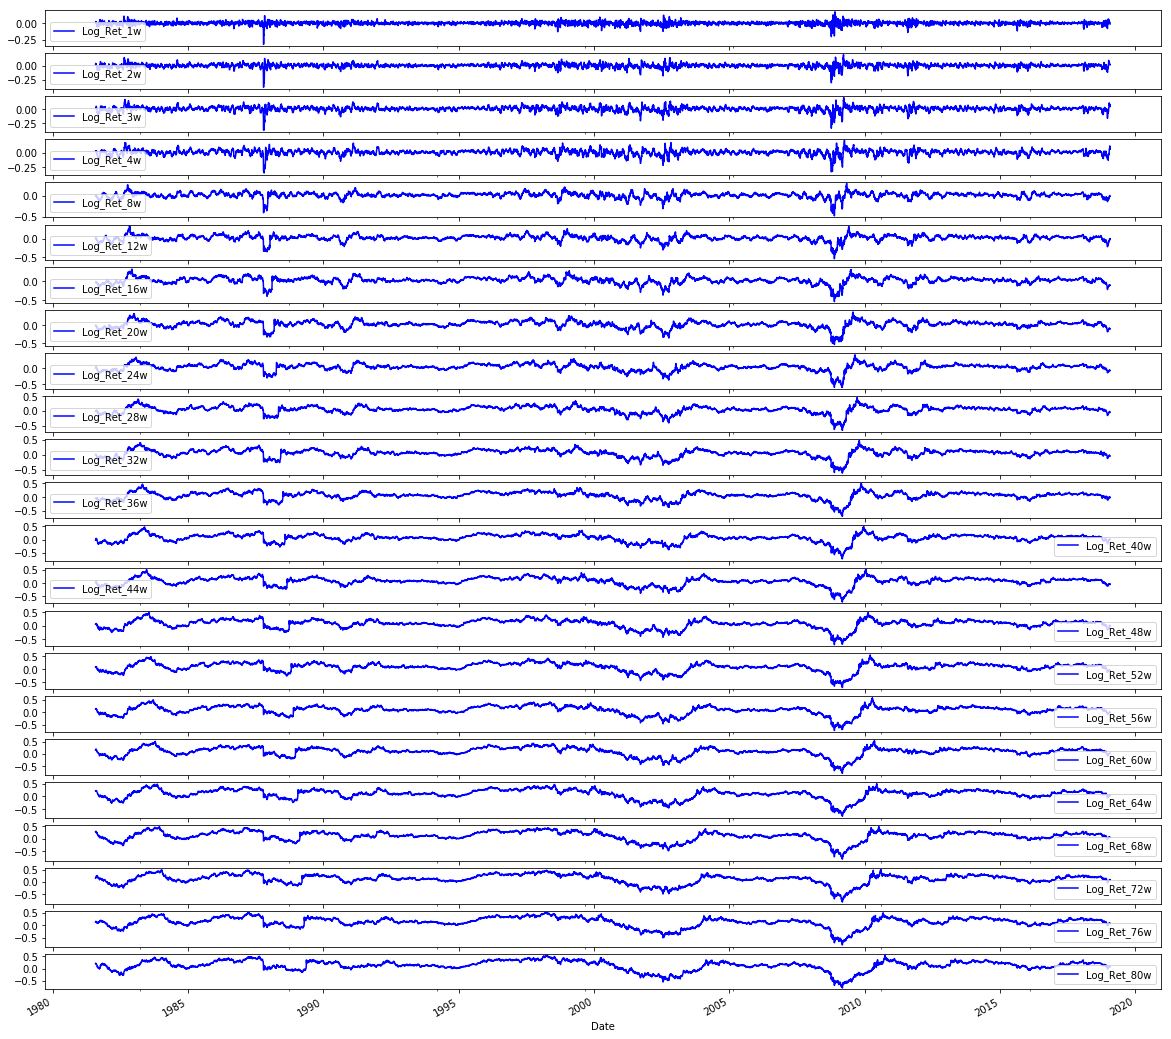

In [7]:
# Plot the logarithmic returns
sp500.iloc[:,1:24].plot(subplots=True, color='blue',figsize=(20, 20));

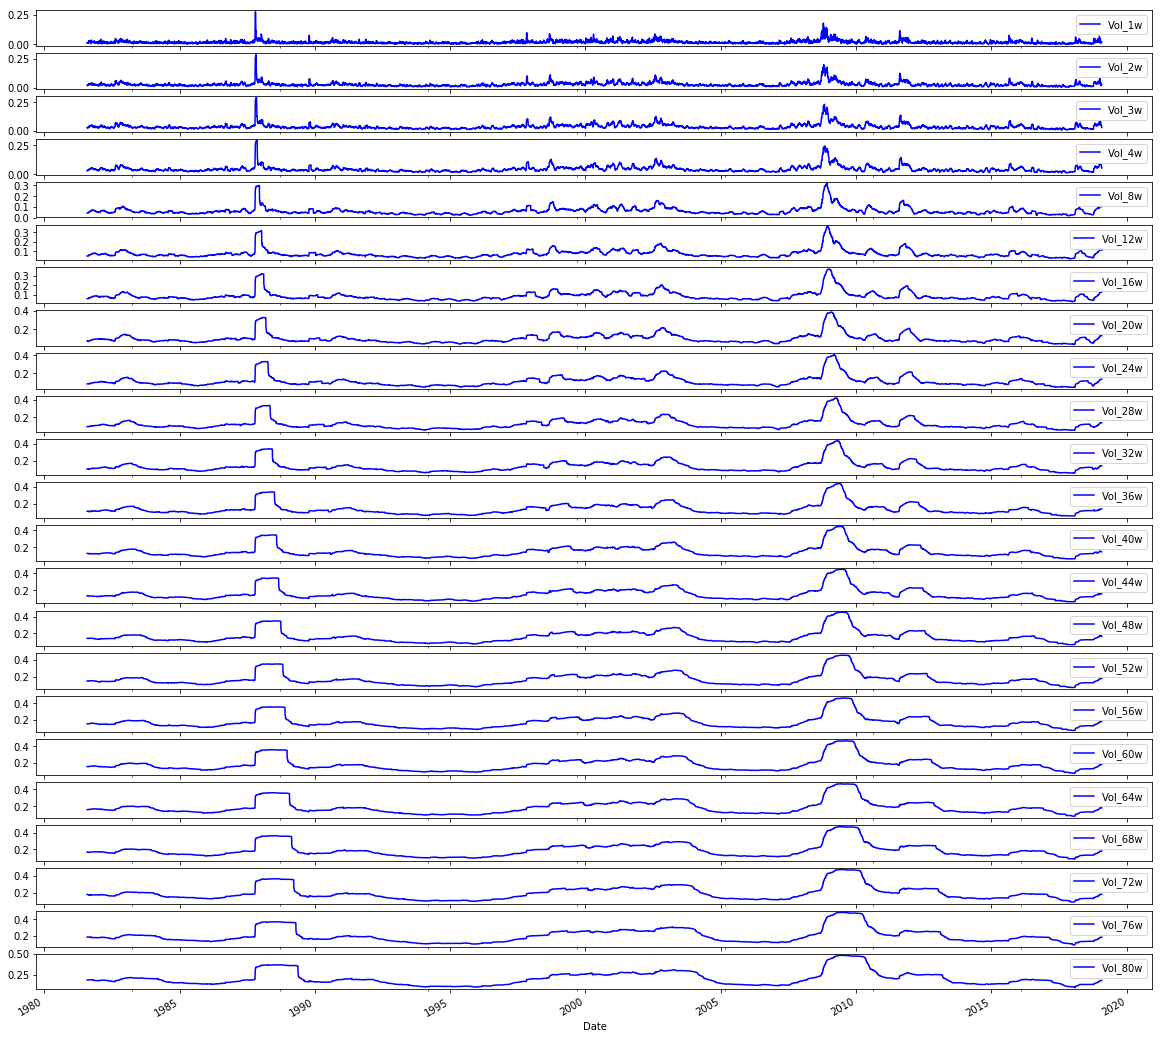

In [8]:
# Plot the Volatilities
sp500.iloc[:,24:47].plot(subplots=True, color='blue',figsize=(20, 20));

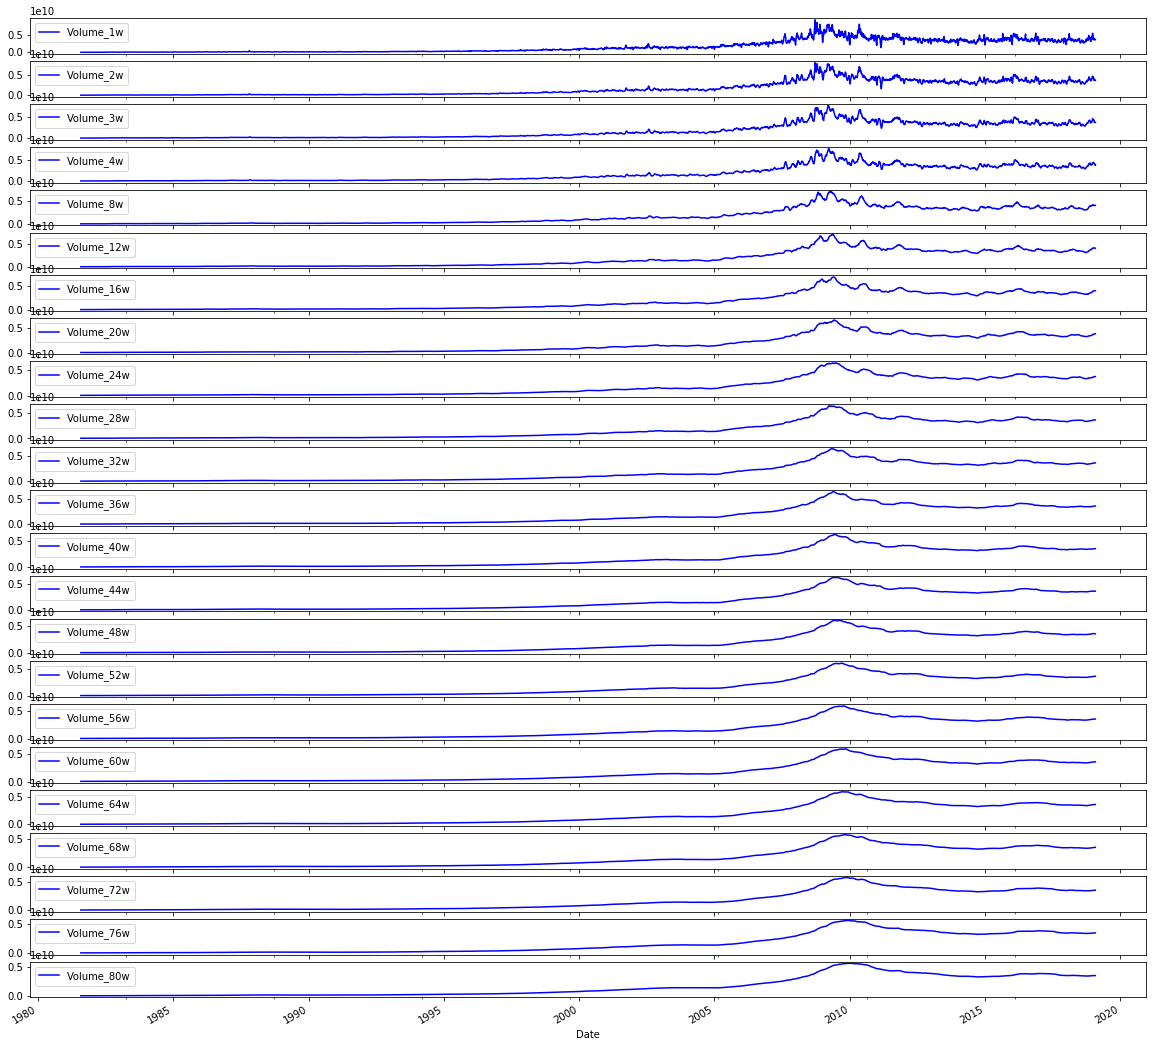

In [9]:
# Plot the Volumes
sp500.iloc[:,47:70].plot(subplots=True, color='blue',figsize=(20, 20));

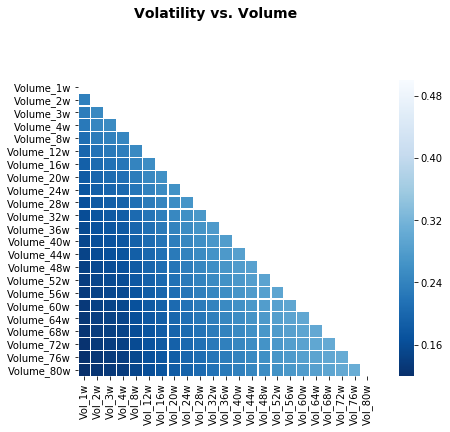

In [10]:
# Plot correlation matrix

focus_cols = sp500.iloc[:,24:47].columns 

corr = sp500.iloc[:,24:70].corr().filter(focus_cols).drop(focus_cols)

mask = np.zeros_like(corr); mask[np.triu_indices_from(mask)] = True # we use mask to plot only part of the matrix

heat_fig, (ax) = plt.subplots(1, 1, figsize=(9,6))

heat = sns.heatmap(corr, 
                   ax=ax, 
                   mask=mask, 
                   vmax=.5, 
                   square=True, 
                   linewidths=.2, 
                   cmap="Blues_r")

heat_fig.subplots_adjust(top=.81)

heat_fig.suptitle('Volatility vs. Volume', fontsize=14, fontweight='bold');

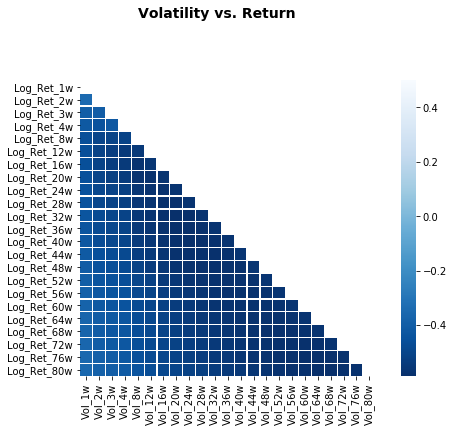

In [11]:
# Plot correlation matrix

focus_cols = sp500.iloc[:,24:47].columns 

corr = sp500.iloc[:,1:47].corr().filter(focus_cols).drop(focus_cols)

mask = np.zeros_like(corr); mask[np.triu_indices_from(mask)] = True # we use mask to plot only part of the matrix

heat_fig, (ax) = plt.subplots(1, 1, figsize=(9,6))

heat = sns.heatmap(corr, 
                   ax=ax, 
                   mask=mask, 
                   vmax=.5, 
                   square=True, 
                   linewidths=.2, 
                   cmap="Blues_r")

heat_fig.subplots_adjust(top=.81)

heat_fig.suptitle('Volatility vs. Return', fontsize=14, fontweight='bold');

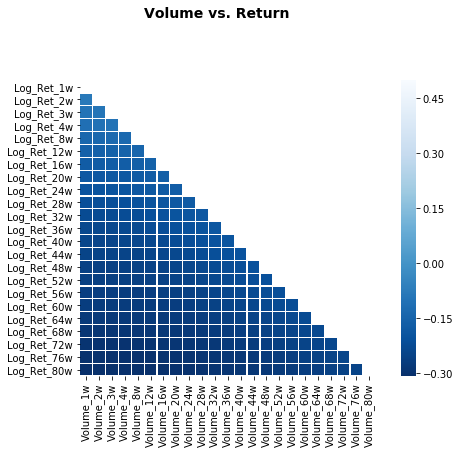

In [12]:
# Plot correlation matrix

focus_cols = sp500.iloc[:,47:70].columns 

corr = sp500.iloc[:, np.r_[1:24, 47:70]].corr().filter(focus_cols).drop(focus_cols)

mask = np.zeros_like(corr); mask[np.triu_indices_from(mask)] = True # we use mask to plot only part of the matrix

heat_fig, (ax) = plt.subplots(1, 1, figsize=(9,6))

heat = sns.heatmap(corr, 
                   ax=ax, 
                   mask=mask, 
                   vmax=.5, 
                   square=True, 
                   linewidths=.2, 
                   cmap="Blues_r")

heat_fig.subplots_adjust(top=.81)

heat_fig.suptitle('Volume vs. Return', fontsize=14, fontweight='bold');

## 4.5 Separate Test Data & Generate Model Sets for Baseline and LSTM Models 

In [13]:
# Model Set 1: Volatility

# Baseline
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(sp500.iloc[:,24:47], sp500.iloc[:,70], test_size=0.1 ,shuffle = False, stratify = None)
# LSTM 
# Input arrays should be shaped as (samples or batch, time_steps or look_back, num_features):
X_train_1_lstm = X_train_1.values.reshape(X_train_1.shape[0], 1, X_train_1.shape[1])
X_test_1_lstm = X_test_1.values.reshape(X_test_1.shape[0], 1, X_test_1.shape[1])

# Model Set 2: Return
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(sp500.iloc[:,1:24], sp500.iloc[:,70], test_size=0.1 ,shuffle = False, stratify = None)
# LSTM 
# Input arrays should be shaped as (samples or batch, time_steps or look_back, num_features):
X_train_2_lstm = X_train_2.values.reshape(X_train_2.shape[0], 1, X_train_2.shape[1])
X_test_2_lstm = X_test_2.values.reshape(X_test_2.shape[0], 1, X_test_2.shape[1])

# Model Set 3: Volume
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(sp500.iloc[:,47:70], sp500.iloc[:,70], test_size=0.1 ,shuffle = False, stratify = None)
# LSTM 
# Input arrays should be shaped as (samples or batch, time_steps or look_back, num_features):
X_train_3_lstm = X_train_3.values.reshape(X_train_3.shape[0], 1, X_train_3.shape[1])
X_test_3_lstm = X_test_3.values.reshape(X_test_3.shape[0], 1, X_test_3.shape[1])

# Model Set 4: Volatility and Return
X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(sp500.iloc[:,1:47], sp500.iloc[:,70], test_size=0.1 ,shuffle = False, stratify = None)
# LSTM 
# Input arrays should be shaped as (samples or batch, time_steps or look_back, num_features):
X_train_4_lstm = X_train_4.values.reshape(X_train_4.shape[0], 1, X_train_4.shape[1])
X_test_4_lstm = X_test_4.values.reshape(X_test_4.shape[0], 1, X_test_4.shape[1])

# Model Set 5: Volatility and Volume
X_train_5, X_test_5, y_train_5, y_test_5 = train_test_split(sp500.iloc[:,24:70], sp500.iloc[:,70], test_size=0.1 ,shuffle = False, stratify = None)
# LSTM 
# Input arrays should be shaped as (samples or batch, time_steps or look_back, num_features):
X_train_5_lstm = X_train_5.values.reshape(X_train_5.shape[0], 1, X_train_5.shape[1])
X_test_5_lstm = X_test_5.values.reshape(X_test_5.shape[0], 1, X_test_5.shape[1])

# Model Set 6: Return and Volume
X_train_6, X_test_6, y_train_6, y_test_6 =  train_test_split(pd.concat([sp500.iloc[:,1:24], sp500.iloc[:,47:70]], axis=1), sp500.iloc[:,70], test_size=0.1 ,shuffle = False, stratify = None)
# LSTM 
# Input arrays should be shaped as (samples or batch, time_steps or look_back, num_features):
X_train_6_lstm = X_train_6.values.reshape(X_train_6.shape[0], 1, X_train_6.shape[1])
X_test_6_lstm = X_test_6.values.reshape(X_test_6.shape[0], 1, X_test_6.shape[1])

# Model Set 7: Volatility, Return and Volume
X_train_7, X_test_7, y_train_7, y_test_7 = train_test_split(sp500.iloc[:,1:70], sp500.iloc[:,70], test_size=0.1 ,shuffle = False, stratify = None)
# LSTM 
# Input arrays should be shaped as (samples or batch, time_steps or look_back, num_features):
X_train_7_lstm = X_train_7.values.reshape(X_train_7.shape[0], 1, X_train_7.shape[1])
X_test_7_lstm = X_test_7.values.reshape(X_test_7.shape[0], 1, X_test_7.shape[1])

## 4.6 Label Distribution

In [14]:
print("train set increase bias = "+ str(np.mean(y_train_7==1))+"%")

print("test set increase bias = " + str(np.mean(y_test_7==1))+"%")

train set increase bias = 0.6244269425179264%
test set increase bias = 0.6437632135306554%


# 5. Workflow

<img src="work-flow.png" width="800" />

### Walk Forward Cross-Validation

Time Series cross-validator provides train/dev indices to split time series data samples that are observed at fixed time intervals, in train/dev sets. In each split, dev indices must be higher than before, and thus shuffling in cross validator is inappropriate. The following graph illustrates how the time series split works:


<img src="walk-forward.png" width="800" />

In [15]:
# Time Series Split 
dev_size = 0.1 #because of computational limitations
n_splits = int((1//dev_size)-1)   # using // for integer division
tscv = TimeSeriesSplit(n_splits=n_splits) 

## Scaling (Standardization/Normalization)

The splitting of the data set during cross-validation should be done before doing any preprocessing. Any process that extracts knowledge from the dataset should only ever be applied to the training portion of the data set, so any cross-validation should be the “outermost loop” in our processing. <br>

The Pipeline class is a class that allows “gluing” together multiple processing steps into a single scikit-learn estimator. The Pipeline class itself has fit, predict and score methods and behaves just like any other model in scikit-learn. The most common use-case of the pipeline class is in chaining preprocessing steps (like scaling of the data) together with a supervised model like a classifier. <br>

For each split in the Walk-Forward CV, the Scaler is refit with only the Sub training splits, not leaking any information of the test split into the parameter search, as illustrated below. 


<img src="scaling.png" width="800" />

**Step 0**: The data is split into TRAINING data and VALIDATION data according to the cv parameter that we specified in the GridSearchCV or RandomizedSearchCV <br>
**Step 1**: the scaler is fitted on the TRAINING data <br>
**Step 2**: the scaler transforms TRAINING data <br>
**Step 3**: the models are fitted/trained using the transformed TRAINING data <br>
**Step 4**: the scaler is used to transform the VALIDATION data <br>
**Step 5**: the trained models predict using the transformed VALIDATION data <br>
**Step 6**: the scaler is fitted on the TRAINING and VALIDATION data <br>
**Step 7**: the scaler transforms TRAINING and VALIDATION data <br>
**Step 8**: the model is fitted/trained using the transformed TRAINING and VALIDATION data and the best found parameters during Walk-Forward CV<br>
**Step 9**: the scaler transforms TEST data <br>
**Step 10**: the trained model predicts using the transformed TEST data <br>






## 6 Regularization 

Regularization adds a penalty on the different parameters of the model to reduce the freedom of the model. Hence, the model will be less likely to fit the noise of the training data and will improve the generalization abilities of the mode


### 6.1 L2 Regularization (Ridge penalisation)

The L2 regularization adds a penalty equal to the sum of the squared value of the coefficients.

$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a_{i}, y_{i}) + \lambda\sum_{i=1}^m\beta_{i}^2\tag{1}$$

The λ parameter is a scalar that should be learned as well, using walk-forward-cross-validation.


The L2 regularization will force the **parameters to be relatively small**, the bigger the penalization, the smaller (and the more robust) the coefficients are.

<img src="ridge.png" width="500" />






### 6.2 L1 Regularization (Lasso penalisation)

The L1 regularization adds a penalty equal to the sum of the absolute value of the coefficients. 

$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a_{i}, y_{i}) + \lambda\sum_{i=1}^m|\beta_{i}|\tag{2}$$

The λ parameter is a scalar that should be learned as well, using walk-forward-cross-validation.

The L1 regularization will **shrink some parameters to zero**. Hence some variables will not play any role in the model, L1 regression can be seen as a way to select features in a model. 


<img src="lasso.png" width="500" />


### 6.3 Elastic Net 

Elastic-net is a **mix of both L1 and L2 regularizations**. A penalty is applied to the sum of the absolute values and to the sum of the squared values:

$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a_{i}, y_{i}) + \lambda((1-\alpha)\sum_{i=1}^m\beta{i}^2+\alpha\sum_{i=1}^m|\beta_{i}|)\tag{3}$$ 

Lambda is a shared penalization parameter while alpha sets the ratio between L1 and L2 regularization in the Elastic Net Regularization. Hence, we expect a hybrid behavior between L1 and L2 regularization.

Though coefficients are cut, the cut is less abrupt than the cut with lasso penalization alone. 

# Models

### Configuration Baseline Models

In [16]:
# Standardized Data
steps_b = [('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logistic', linear_model.SGDClassifier(random_state=1, loss = "log", tol=1e-3, shuffle=False, early_stopping=False))]

#Normalized Data
#steps_b = [('scaler', MinMaxScaler(feature_range=(0, 1), copy=True)), ('logistic', linear_model.SGDClassifier(random_state=1, tol=1e-3, shuffle=False, early_stopping=False))]

# Using pipeline we glue together the Scaler & the Classifier
# This ensure that during cross validation the Scaler is fitted to only the training folds
pipeline_b = Pipeline(steps_b)

# Create loss function
#loss_b = ["log"]

# Penalty
penalty_b = ['l1','l2', 'elasticnet']

# Evaluation Metric
scoring_b = {'AUC': 'roc_auc', 'accuracy': make_scorer(accuracy_score)}
metric_b = 'accuracy'

### Configuration LSTM Models

In [17]:
# Batch_input_shape = [1, 1, Z]  -> (batch size, time steps, number of features) 
# Data set inputs(trainX) = [X, 1, Z]  -> (samples, time steps, number of features)  

# number of samples
num_samples = 1

# time_steps
look_back = 1

# Dense
Dense_units = 1

# Evaluation Metric
scoring_lstm = 'accuracy'
metric_lstm = 'accuracy'

# 6 Models

## Model 1: Volatility

## Baseline 

Loss function: log
accuracy of the best model:  0.5432539682539682


Best hyperparameters:
Number of iterations: 8
Penalty: l2
Alpha: 0.0013
l1_ratio: 0
Total number of features: 23
Number of selected features: 23


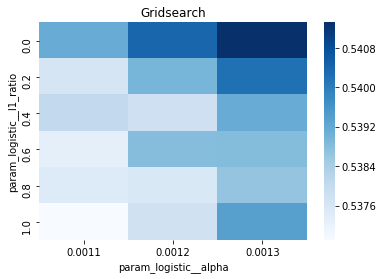

In [51]:
# Model specific Parameter 

# Number of iterations
iterations_1_b = [8] 


# Grid Search

# Regularization  
alpha_g_1_b = [0.0011, 0.0012, 0.0013]
l1_ratio_g_1_b = [0, 0.2, 0.4, 0.6, 0.8, 1] 

# Create hyperparameter options
hyperparameters_g_1_b = {'logistic__alpha':alpha_g_1_b, 'logistic__l1_ratio':l1_ratio_g_1_b, 'logistic__penalty':penalty_b,  'logistic__max_iter':iterations_1_b}

# Create grid search 
search_g_1_b = GridSearchCV(estimator=pipeline_b, param_grid=hyperparameters_g_1_b, cv=tscv, verbose=0, n_jobs=-1, scoring=scoring_b, refit=metric_b, return_train_score=False)
# Setting refit='Accuracy', refits an estimator on the whole dataset with the parameter setting that has the best cross-validated mean Accuracy score. 
# For multiple metric evaluation, this needs to be a string denoting the scorer is used to find the best parameters for refitting the estimator at the end
# If return_train_score=True training results of CV will be saved as well 

# Fit grid search
tuned_model_1_b = search_g_1_b.fit(X_train_1, y_train_1)
#search_g_1_b.cv_results_


# Random Search

# Create regularization hyperparameter distribution using uniform distribution
#alpha_r_1_b = uniform(loc=0.00006, scale=0.002) #loc=0.00006, scale=0.002
#l1_ratio_r_1_b = uniform(loc=0, scale=1) 

# Create hyperparameter options
#hyperparameters_r_1_b = {'logistic__alpha':alpha_r_1_b, 'logistic__l1_ratio':l1_ratio_r_1_b, 'logistic__penalty':penalty_b,'logistic__max_iter':iterations_1_b}

# Create randomized search 
#search_r_1_b = RandomizedSearchCV(pipeline_b, hyperparameters_r_1_b, n_iter=10, random_state=1, cv=tscv, verbose=0, n_jobs=-1, scoring=scoring_b, refit = metric_b, return_train_score=True)
# Setting refit='Accuracy', refits an estimator on the whole dataset with the parameter setting that has the best cross-validated Accuracy score.

# Fit randomized search
#tuned_model_1_b = search_r_1_b.fit(X_train_1, y_train_1)



# View Cost function
print('Loss function:', tuned_model_1_b.best_estimator_.get_params()['logistic__loss'])

# View Accuracy 
print(metric_b +' of the best model: ', tuned_model_1_b.best_score_);print("\n")
# best_score_ Mean cross-validated score of the best_estimator

# View best hyperparameters
print("Best hyperparameters:")
print('Number of iterations:', tuned_model_1_b.best_estimator_.get_params()['logistic__max_iter'])
print('Penalty:', tuned_model_1_b.best_estimator_.get_params()['logistic__penalty'])
print('Alpha:', tuned_model_1_b.best_estimator_.get_params()['logistic__alpha'])
print('l1_ratio:', tuned_model_1_b.best_estimator_.get_params()['logistic__l1_ratio'])

# Find the number of nonzero coefficients (selected features)
print("Total number of features:", len(tuned_model_1_b.best_estimator_.steps[1][1].coef_[0][:]))
print("Number of selected features:", np.count_nonzero(tuned_model_1_b.best_estimator_.steps[1][1].coef_[0][:]))

# Gridsearch table
plt.title('Gridsearch')
pvt_1_b = pd.pivot_table(pd.DataFrame(tuned_model_1_b.cv_results_), values='mean_test_accuracy', index='param_logistic__l1_ratio', columns='param_logistic__alpha')
ax_1_b = sns.heatmap(pvt_1_b, cmap="Blues")
plt.show()

### Confusion Matrix

Accuracy: 0.6479915433403806
Precision: 0.6561085972850679
Recall: 0.9523809523809523


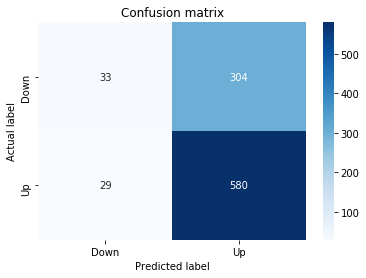

In [50]:
# Make predictions
y_pred_1_b = tuned_model_1_b.predict(X_test_1)

# create confustion matrix
fig, ax = plt.subplots()
sns.heatmap(pd.DataFrame(metrics.confusion_matrix(y_test_1, y_pred_1_b)), annot=True, cmap="Blues" ,fmt='g')
plt.title('Confusion matrix'); plt.ylabel('Actual label'); plt.xlabel('Predicted label')
ax.xaxis.set_ticklabels(['Down', 'Up']); ax.yaxis.set_ticklabels(['Down', 'Up'])

print("Accuracy:",metrics.accuracy_score(y_test_1, y_pred_1_b))
print("Precision:",metrics.precision_score(y_test_1, y_pred_1_b))
print("Recall:",metrics.recall_score(y_test_1, y_pred_1_b))

### ROC Curve

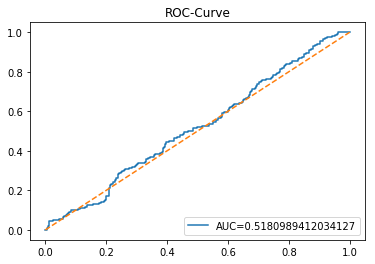

In [46]:
y_proba_1_b = tuned_model_1_b.predict_proba(X_test_1)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test_1,  y_proba_1_b)
auc = metrics.roc_auc_score(y_test_1, y_proba_1_b)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
plt.plot([0, 1], [0, 1], linestyle='--') # plot no skill
plt.title('ROC-Curve')
plt.show()

## LSTM Model (In development)

In [ ]:
start = time.time()


# Model specific Parameter 

# numer of features
num_features_1_lstm = X_test_1.shape[1]

# number of units 
LSTM_units_1_lstm = 2

epochs = [1,2]
batch_size = 1

# Regularization
recurrent_regularizer = [L1L2(l1=0.2, l2=0.1)]
activity_regularizer  = L1L2(l1=0., l2=0.) 

dropout_rate = 0.0
recurrent_dropout=0.5


hyperparameter_1_lstm = {'epochs':epochs, 'recurrent_regularizer':recurrent_regularizer, 'activity_regularizer':[activity_regularizer]}

#'batch_size':[batch_size],
#'dropout_rate':[dropout_rate]}
#'recurrent_dropout':[recurrent_dropout]

# create Classifier
clf_1_lstm = KerasClassifier(build_fn=create_shallow_LSTM, look_back = look_back, batch_size=batch_size, num_features= num_features_1_lstm, num_samples=num_samples, LSTM_units=LSTM_units_1_lstm, recurrent_dropout=recurrent_dropout, dropout_rate=dropout_rate, Dense_units=Dense_units, verbose=1)



# Standardized Data
#steps = [(scaler, scaler), ('clf', clf)]
#Normalized Data
#steps = [('scaler', MinMaxScaler(feature_range=(-1, 1), copy=True)), ('clf', clf)]
# Using pipeline we glue together the Scaler & the Classifier
# This ensure that during cross validation the Scaler is fitted to only the training folds
#pipeline = Pipeline(steps)



search_1_lstm = GridSearchCV(clf_1_lstm, hyperparameter_1_lstm,  n_jobs=-1,  cv=tscv, scoring=scoring_lstm, refit=True, return_train_score=False)

#random_state=2
#n_iter=1,

tuned_model_1_lstm = search_1_lstm.fit(X_train_1_lstm, y_train_1, shuffle=False, callbacks=[reset])



print("\n")

# View Accuracy 
print(metric_lstm +' of the best model: ', tuned_model_1_lstm.best_score_)
# best_score_ Mean cross-validated score of the best_estimator

print("\n")

# View best hyperparameters
print("Best hyperparameters:")
print('epochs:', tuned_model_1_lstm.best_estimator_.get_params()['epochs'])
print('batch_size:', tuned_model_1_lstm.best_estimator_.get_params()['batch_size'])
print('dropout_rate:', tuned_model_1_lstm.best_estimator_.get_params()['recurrent_dropout'])

end = time.time()
print("\n")
print("Running Time:", end - start)

In [ ]:
tuned_model_1_lstm.cv_results_

In [ ]:
tuned_model_1_b.cv_results_

### Confusion Matrix

In [ ]:
# Make predictions
y_pred_1_lstm = tuned_model_1_lstm.predict(X_test_1_lstm)

# create confustion matrix
fig, ax = plt.subplots()
sns.heatmap(pd.DataFrame(metrics.confusion_matrix(y_test_7, y_pred_1_lstm)), annot=True, cmap="Blues" ,fmt='g')
plt.title('Confusion matrix'); plt.ylabel('Actual label'); plt.xlabel('Predicted label')
ax.xaxis.set_ticklabels(['Down', 'Up']); ax.yaxis.set_ticklabels(['Down', 'Up'])

print("Accuracy:",metrics.accuracy_score(y_test_1, y_pred_1_lstm))
print("Precision:",metrics.precision_score(y_test_1, y_pred_1_lstm))
print("Recall:",metrics.recall_score(y_test_1, y_pred_1_lstm))

### ROC Curve

In [ ]:
y_proba_1_lstm = tuned_model_1_lstm.predict_proba(X_test_1_lstm)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test_1,  y_proba_1_lstm)
auc = metrics.roc_auc_score(y_test_1, y_proba_1_lstm)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
plt.plot([0, 1], [0, 1], linestyle='--') # plot no skill
plt.title('ROC-Curve')
plt.show()

In [ ]:
y_proba_1_lstm